In [148]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #faire des graphes 
import seaborn as sns # faire des graphiques plus jolis
import sklearn as sk

In [149]:
import os

os.getcwd()

## Changer le répertoire de travail
os.chdir(r'C:\Users\admin\Desktop\ISE_22\ML_Project')

# Lire les fichiers CSV et les charger dans des dataframes

item_categories = pd.read_csv('item_categories.csv')

items = pd.read_csv('items.csv')

sales_train = pd.read_csv('sales_train.csv')

sample_submission = sample_submission = pd.read_csv('sample_submission.csv')

shops = pd.read_csv('shops.csv')

test = pd.read_csv('test.csv')

In [309]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
5,5,0.5
6,6,0.5
7,7,0.5
8,8,0.5
9,9,0.5


In [310]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## Preprocessing

In [150]:
# convertir la target en integer
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].astype(np.int64)
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day        int64
dtype: object

#### On constate que la valeur minimale de la variable item_cnt_day est -22 et celle de item_price -1
#### Supposons qu'il s'agit d'une erreur de saisie et appliquons la valeur absolue sur ces variables

In [151]:
sales_train["item_cnt_day"] = np.abs(sales_train["item_cnt_day"])
sales_train["item_price"] = np.abs(sales_train["item_price"])

sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.247778e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.616391e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


#### Examinons la présence des valeurs abérrantes

<AxesSubplot:xlabel='item_price'>

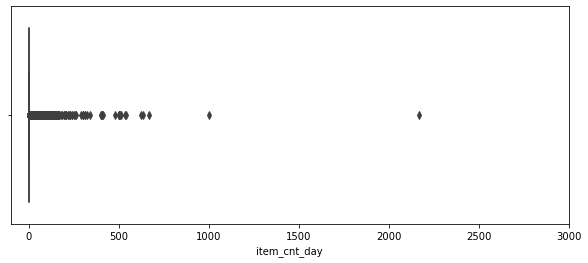

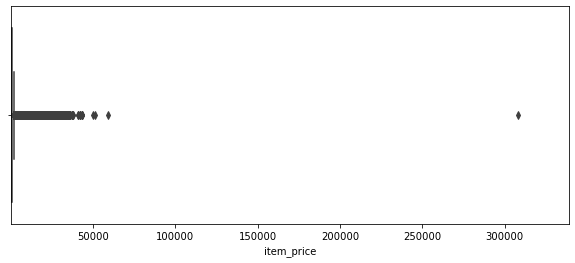

In [152]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales_train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.1)
sns.boxplot(x=sales_train.item_price)

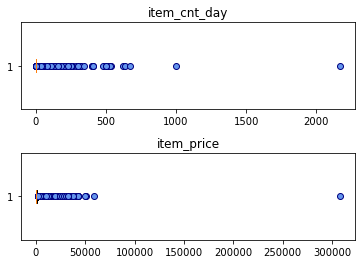

In [153]:
fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.5)

flierprops = dict(marker='o', markerfacecolor='cornflowerblue', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=sales_train.item_cnt_day, flierprops=flierprops, vert=False)
_ = axes[1].boxplot(x=sales_train.item_price, flierprops=flierprops, vert=False)

_ = axes[0].set_title('item_cnt_day')
_ = axes[1].set_title('item_price')

In [154]:
sales_train = sales_train[sales_train.item_price<100000]
sales_train = sales_train[sales_train.item_cnt_day<1001]
sales_train=sales_train[sales_train['item_price'] > 0]
sales_train = sales_train[sales_train['item_cnt_day'] > 0]

In [155]:
sales_train['revenue'] = sales_train['item_price']*sales_train['item_cnt_day']

In [156]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1,999.00
1,03.01.2013,0,25,2552,899.00,1,899.00
2,05.01.2013,0,25,2552,899.00,1,899.00
3,06.01.2013,0,25,2554,1709.05,1,1709.05
4,15.01.2013,0,25,2555,1099.00,1,1099.00


In [157]:
## Merge some duplicate shops
sales_train["shop_id"] = sales_train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

# Keep only shops that are in the test set
sales_train = sales_train.loc[sales_train.shop_id.isin(test["shop_id"].unique()), :]
sales_train.dropna(axis=1,inplace=True)

In [158]:
daily = sales_train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
daily = daily.groupby(['date'], as_index=False)
daily = daily.agg({'item_cnt_day':['sum']})
daily.head()

,date,item_cnt_day
,,sum
0,01.01.2013,1121
1,01.01.2014,1392
2,01.01.2015,1392
3,01.02.2013,2960
4,01.02.2014,4459


In [159]:
monthly_per_shop = sales_train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
monthly_per_shop = monthly_per_shop.groupby(['date_block_num','shop_id'], as_index=False)
monthly_per_shop = monthly_per_shop.agg({'item_cnt_day':['sum']})
monthly_per_shop['item_cnt_month']  = monthly_per_shop['item_cnt_day']['sum']
monthly_per_shop = monthly_per_shop.drop(['item_cnt_day'], axis=1)
monthly_per_shop.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_15716\4086479650.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  monthly_per_shop = monthly_per_shop.drop(['item_cnt_day'], axis=1)


,date_block_num,shop_id,item_cnt_month
,,,
0,0,2,1156
1,0,3,767
2,0,4,2120
3,0,6,3712
4,0,7,2501


#### Séparons la ville et le nom de la boutique

In [160]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name"] = 'СергиевПосад ТЦ "7Я"'

In [161]:
shops["city"] = shops.shop_name.str.split(' ').map(lambda x: x[0])

In [162]:
shops["shop_category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск" 

In [163]:
from sklearn.preprocessing import LabelEncoder

# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])
# Shop Category Label Encoding 
shops['shop_category'] = label_encoder.fit_transform(shops['shop_category']) 

In [164]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city,shop_category
0,0,29,4
1,1,29,8
2,2,0,8
3,3,1,6
4,4,2,8


In [165]:
items = items.drop(['item_name'], axis=1)

In [166]:
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,15.0
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [167]:
items[items['first_sale_date'].isna()]

,item_id,item_category_id,first_sale_date
0,0,40,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
5,5,40,NaN
...,...,...,...
21975,21975,61,NaN
22022,22022,40,NaN
22028,22028,40,NaN
22035,22035,40,NaN


In [168]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

In [169]:
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  
item_categories['category'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: category, dtype: int64

In [170]:
def make_etc(x):
    if len(item_categories[item_categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

In [171]:
# Replace with 'etc' if category count is less than 5
item_categories['category'] = item_categories['category'].apply(make_etc) 

In [174]:
# Create Label Encoder
label_encoder = LabelEncoder()

In [175]:
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])

In [176]:
item_categories = item_categories.drop('item_category_name', axis=1)

In [177]:
from itertools import product

train = []
# Create date_block_num, shop_id, item_id combination
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

In [178]:
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [179]:
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

In [180]:
train = train.merge(group, on=idx_features, how='left') 
train.head() 

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


import gc

del group
gc.collect();

group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

del group, sales_train
gc.collect()

train.head()

In [181]:
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

all_data.head() 

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


In [182]:
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left') 

In [183]:
all_data = downcast(all_data) 

NameError: name 'downcast' is not defined

In [184]:
del shops, items, item_categories
gc.collect(); 

In [185]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary
resumetable(all_data)

Data Shape: (8861271, 10)


,Dtypes,Null,Uniques,First_values,Second_values,Third_values
date_block_num,int64,0,35,0.0,0.0,0.0
shop_id,int64,0,42,59.0,59.0,59.0
item_id,int64,0,21469,22154.0,2552.0,2554.0
item_cnt_month,float64,0,407,1.0,0.0,0.0
item_price_mean,float64,0,35027,999.0,0.0,0.0
city,int32,0,28,30.0,30.0,30.0
shop_category,int32,0,11,8.0,8.0,8.0
item_category_id,int64,0,84,37.0,58.0,58.0
first_sale_date,float64,0,35,0.0,0.0,0.0
category,int64,0,10,5.0,7.0,7.0


In [78]:
all_data[["date_block_num", "item_cnt_month"]].corr()

,category,item_cnt_month
category,1.000000,-0.041902
item_cnt_month,-0.041902,1.000000


In [79]:
all_data[["shop_id", "item_cnt_month"]].corr()

,shop_id,item_cnt_month
shop_id,1.000000,0.007206
item_cnt_month,0.007206,1.000000


In [80]:
all_data[["item_price_mean", "item_cnt_month"]].corr() 

,item_price_mean,item_cnt_month
item_price_mean,1.000000,0.123836
item_cnt_month,0.123836,1.000000


In [82]:
all_data[["city", "item_cnt_month"]].corr()

,city,item_cnt_month
city,1.000000,0.006432
item_cnt_month,0.006432,1.000000


In [83]:
all_data[["shop_category", "item_cnt_month"]].corr()

,shop_category,item_cnt_month
shop_category,1.000000,-0.011082
item_cnt_month,-0.011082,1.000000


In [84]:
all_data[["item_category_id", "item_cnt_month"]].corr()

,item_category_id,item_cnt_month
item_category_id,1.000000,-0.029946
item_cnt_month,-0.029946,1.000000


In [85]:
all_data[["first_sale_date", "item_cnt_month"]].corr()

,first_sale_date,item_cnt_month
first_sale_date,1.00000,0.01963
item_cnt_month,0.01963,1.00000


In [86]:
all_data[["category", "item_cnt_month"]].corr()

,category,item_cnt_month
category,1.000000,-0.041902
item_cnt_month,-0.041902,1.000000


### Modelisation

#### Split

In [186]:
final_train_df = all_data[all_data.date_block_num<=27]
final_test_df = all_data[all_data.date_block_num>27]

y_train = final_train_df[["item_cnt_month"]]
x_train = final_train_df.drop("item_cnt_month", axis = 1)
 
y_test = final_test_df[["item_cnt_month"]] 
x_test = final_test_df.drop("item_cnt_month", axis = 1) 


#### Regression lineaire

In [187]:
from sklearn.linear_model import LinearRegression

Modele = LinearRegression(fit_intercept = True)
Modele.fit(x_train, y_train)
train_score = Modele.score(x_train, y_train)
test_score = Modele.score(x_test, y_test)

train_score, test_score

(0.020259993346635863, 0.006378882793819374)

In [188]:
coefs_Modele = Modele.coef_
print(coefs_Modele)

[[-8.68252718e-03  9.94693316e-03 -2.25040178e-06  6.60616840e-04
  -1.82025430e-02 -1.91200193e-02  2.78619046e-02  1.39976349e-02
  -2.73734277e-01]]


In [189]:
#### Erreur quadratique moyenne
from sklearn.metrics import mean_squared_error 

y_train_predict = Modele.predict(x_train)
y_test_predict = Modele.predict(x_test)
erreur_train = mean_squared_error(y_train, y_train_predict, squared = False) 
erreur_test = mean_squared_error(y_test, y_test_predict, squared = False)

erreur_train, erreur_test

(3.3473785351834744, 3.496260219711276)

#### LASSO

In [190]:
from sklearn.linear_model import Lasso

Modele_lasso = Lasso(fit_intercept = True, alpha = 5)
Modele_lasso.fit(x_train, y_train)
train_score = Modele_lasso.score(x_train, y_train)
test_score = Modele_lasso.score(x_test, y_test)

train_score, test_score

(0.01728362552826035, 0.005496993693419494)

In [191]:
coefs = Modele_lasso.coef_
print(coefs)

[-0.00000000e+00  0.00000000e+00 -4.62067053e-06  6.69190537e-04
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00]


####  SGD

In [192]:
from sklearn.ensemble import GradientBoostingRegressor

Modele_SGB = GradientBoostingRegressor()
Modele_SGB.fit(x_train, y_train)
train_score = Modele_SGB.score(x_train, y_train)
test_score = Modele_SGB.score(x_test, y_test)

train_score, test_score


C:\Users\admin\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.3697643303932385, 0.15861846731420037)

#### Random Forest

In [193]:
from sklearn.ensemble import RandomForestRegressor

In [194]:
! pip install --upgrade pip
! pip install yellowbrick
! pip install xgboost

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.model_selection import LearningCurve
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import CooksDistance
from yellowbrick.model_selection import ValidationCurve

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer


In [196]:
# Creating Numerical Transformer
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

In [197]:
X= train 
y = X.pop('item_cnt_month')

In [198]:
# Bundling Preprocessors
preprocessor = ColumnTransformer(
    transformers=[('numerical', numerical_transformer, X.columns),])

In [65]:
# Creating Model
rfg_model = RandomForestRegressor(
    n_estimators=250,
    criterion='squared_error',
    random_state=0,
)

rfg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rfg_model),
])

In [66]:
# Training and Predicting
rfg_pipeline.fit(x_train, y_train)
print('Training: Done!')
rfg_predictions = rfg_pipeline.predict(x_test)
print('Predictions: Done!')


C:\Users\admin\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Training: Done!
Predictions: Done!


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Définition des valeurs à essayer pour chaque hyperparamètre
param_grid = {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}

# Création de la grille de recherche
grid_search = GridSearchCV(rfg_model, param_grid, cv=5, scoring="neg_mean_absolute_error")

# Entraînement du modèle avec la grille de recherche
grid_search.fit(x_train, y_train)

# Affiche le meilleur jeu d'hyperparamètres trouvé
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Évaluation du modèle avec les meilleurs hyperparamètres sur les données de test
score = grid_search.score(x_test, y_test)

print("Score du modèle : {:.2f}".format(score))

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

In [52]:
rfg_model = RandomForestRegressor(
    criterion='squared_error',
    random_state=0,
    max_depth= None,
    max_features= 4,
    min_samples_leaf= 1,
    min_samples_split= 10,
    n_estimators=  200

)


In [53]:
rfg_pipeline.fit(x_train, y_train)
print('Training: Done!')
rfg_predictions = rfg_pipeline.predict(x_test)
print('Predictions: Done!')

c:\Users\dell\anaconda3\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Training: Done!
Predictions: Done!


In [54]:
train_score = rfg_pipeline.score(x_train, y_train)
test_score = rfg_pipeline.score(x_test, y_test)

train_score, test_score

(0.9831576523987972, 0.7927208321600562)

## XGBOOST REGRESSOR

In [199]:
from xgboost import XGBRegressor

In [200]:
# Creating the Model
xgb_model = XGBRegressor(
    n_estimators=500
    , learning_rate=0.05
    , n_jobs=4
)

In [201]:
xgb_model.fit(
    x_train, y_train
    , early_stopping_rounds=5
    , eval_set=[(x_test, y_test)]
    , verbose=False
)
print('Training: Done!')

xgb_predictions = xgb_model.predict(x_test)
print('Predictions: Done!')

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training: Done!
Predictions: Done!


In [202]:
train_score =xgb_model.score(x_train, y_train)
test_score = xgb_model.score(x_test, y_test)

train_score, test_score

(0.22169011655431492, 0.10911292308726817)

### CHANGEMENT DE METHODE

In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #faire des graphes 
import seaborn as sns # faire des graphiques plus jolis
import sklearn as sk

In [2]:
import os
#afficher le répertoire courant
os.getcwd()
os.chdir(r'C:\Users\admin\Desktop\ISE_22\ML_Project')
item_categories = pd.read_csv('item_categories.csv')

items = pd.read_csv('items.csv')

sales_train = pd.read_csv('sales_train.csv')

sample_submission = sample_submission = pd.read_csv('sample_submission.csv')

shops = pd.read_csv('shops.csv')

test = pd.read_csv('test.csv')

In [3]:
base1 = items.merge(item_categories, on = "item_category_id", how = "left")

In [4]:
base2 = sales_train.merge(shops, on = "shop_id", how = "left")

In [5]:
base_globale = base2.merge(base1, on = "item_id", how = "left")

In [6]:
# Gardons les variables importantes: shop_id, item_id, date_block_num et item_cnt_day

base_globale = base_globale[["date_block_num","shop_id", "item_id","item_cnt_day","item_category_id"]]

base_globale.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id
0,0,59,22154,1.0,37
1,0,25,2552,1.0,58
2,0,25,2552,-1.0,58
3,0,25,2554,1.0,58
4,0,25,2555,1.0,56


In [7]:
base_globale.describe()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,2.169000e+03,8.300000e+01


In [9]:
# On constate que la valeur minimale de item_cnt_day est -22, bizarre parceque c'est le nombre de produits vendus par jour,

# Corrigéons cela en appliquant une valeur absolue à cette variable

base_globale["item_cnt_day"] = np.abs(base_globale["item_cnt_day"])

array([[<AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>],
       [<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>],
       [<AxesSubplot:title={'center':'item_category_id'}>,
        <AxesSubplot:>]], dtype=object)

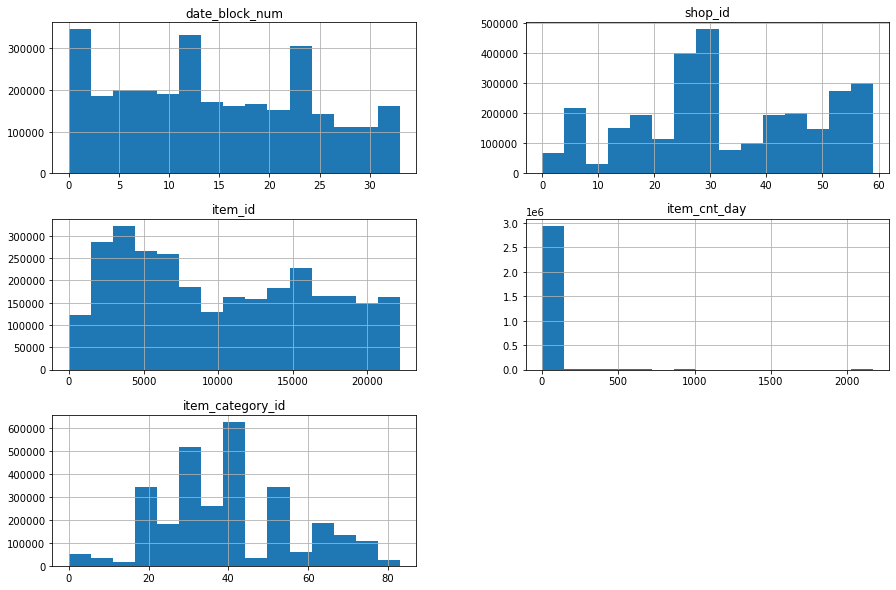

In [10]:
base_globale.hist(bins=15, figsize=(15, 10))

In [11]:
# Groupons les lignes qui ont les memes valeurs sauf pour item_cnt_day(dont les valeurs sont sommées)
grouped_base_globale = base_globale.groupby(by = ['date_block_num', 'shop_id'], as_index=False).agg({"item_cnt_day":"sum"})

grouped_base_globale.head()

,date_block_num,shop_id,item_cnt_day
0,0,0,5578.0
1,0,1,2947.0
2,0,2,1156.0
3,0,3,767.0
4,0,4,2120.0


#### Transformons la variable shop_id en une variable dummies

In [ ]:
### pour transformer shop_id en variable dummies
#grouped_base_globale = pd.get_dummies(grouped_train_df)

#grouped_base_globale.head()

In [12]:
grouped_base_globale["shop_id"] = grouped_base_globale["shop_id"].astype(str)

### Split

In [18]:
final_train_df = grouped_base_globale[grouped_base_globale.date_block_num<=27]
final_test_df = grouped_base_globale[grouped_base_globale.date_block_num>27]

# Keep only shops that are in the test set

final_test_df = final_test_df.loc[final_test_df.shop_id.isin(final_train_df["shop_id"].unique()), :]

y_train = final_train_df[["item_cnt_day"]]
x_train = final_train_df.drop("item_cnt_day", axis = 1)
 
y_test = final_test_df[["item_cnt_day"]] 
x_test = final_test_df.drop("item_cnt_day", axis = 1)


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [15]:
numeric_features = x_train.select_dtypes(include=["int64", 'float64']).columns
categorical_features = x_train.select_dtypes(include=["object"]).columns
    
numerical_transformer = Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer()), ("encoder", OneHotEncoder())])
preprocessor = ColumnTransformer(
      transformers=[
          ("num", numerical_transformer, numeric_features),
          ("cat", categorical_transformer, categorical_features)
      ]
  )

In [20]:
numeric_features, categorical_features

(Index(['date_block_num'], dtype='object'), Index(['shop_id'], dtype='object'))

### Modèle Linéaire

In [19]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression(fit_intercept = True)
Modele = Pipeline(steps=[("preprocess", preprocessor), ("linear_model", regression)])
Modele.fit(x_train, y_train)
train_score = Modele.score(x_train, y_train)
test_score = Modele.score(x_test, y_test)

train_score, test_score

(0.8529162717568549, 0.4527384349673952)

In [ ]:
##(0.8529162717568549, 0.45015422643530933)

#### Vérifions Erreur Quadratique Moyenne

In [217]:
#### Erreur quadratique moyenne
from sklearn.metrics import mean_squared_error 

y_train_predict = Modele.predict(x_train)
y_test_predict = Modele.predict(x_test)
erreur_train = mean_squared_error(y_train, y_train_predict, squared = False) 
erreur_test = mean_squared_error(y_test, y_test_predict, squared = False)

erreur_train, erreur_test

(759.3460387345258, 952.7232905127324)

### Regression LASSO

In [21]:
from sklearn.linear_model import Lasso

lasso = Lasso(fit_intercept = True, alpha = 5)
Modele_lasso = Pipeline(steps=[("preprocess", preprocessor), ("lasso_model", lasso)])
Modele_lasso.fit(x_train, y_train)
train_score = Modele_lasso.score(x_train, y_train)
test_score = Modele_lasso.score(x_test, y_test)

train_score, test_score

(0.8271798629452891, 0.5241116586951103)

#### Vérifions Erreur Quadratique Moyenne

In [219]:
#### Erreur quadratique moyenne
from sklearn.metrics import mean_squared_error 

y_train_predict = Modele_lasso.predict(x_train)
y_test_predict = Modele_lasso.predict(x_test)
erreur_train = mean_squared_error(y_train, y_train_predict, squared = False) 
erreur_test = mean_squared_error(y_test, y_test_predict, squared = False)

erreur_train, erreur_test

(823.193356952202, 884.2709561084579)

### Modèle SGD

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
SGD = GradientBoostingRegressor()
Modele_SGD = Pipeline(steps=[("preprocess", preprocessor), ("SGD_model", SGD)])
Modele_SGD.fit(x_train, y_train)
train_score = Modele_SGD.score(x_train, y_train)
test_score = Modele_SGD.score(x_test, y_test)

train_score, test_score

C:\Users\admin\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.8956577938104787, 0.7199825155307452)

In [ ]:
(0.8956577938104787, 0.7179101679967851)

#### Erreur Quadratique Moyenne

In [221]:
#### Erreur quadratique moyenne
from sklearn.metrics import mean_squared_error 

y_train_predict = Modele_SGB.predict(x_train)
y_test_predict = Modele_SGB.predict(x_test)
erreur_train = mean_squared_error(y_train, y_train_predict, squared = False) 
erreur_test = mean_squared_error(y_test, y_test_predict, squared = False)

erreur_train, erreur_test

(639.5690281809218, 682.4016256086317)

### XGBOOST REGRESSOR

In [38]:
from xgboost.sklearn import XGBRegressor

In [39]:
# Creating the Model
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4)

xgb_model = Pipeline(steps=[("preprocess", preprocessor), ("xgb_model", xgb)])

In [49]:
transformer = preprocessor.fit(x_train, y_train)
x_test_eval = transformer.transform(x_test)

In [50]:
xgb_model.fit(
    x_train, y_train
    , xgb_model__early_stopping_rounds=5, xgb_model__eval_set=[(x_test_eval, y_test)], xgb_model__verbose=False)
print('Training: Done!')

xgb_predictions = xgb_model.predict(x_test)
print('Predictions: Done!')

Training: Done!
Predictions: Done!


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [51]:
train_score =xgb_model.score(x_train, y_train)
test_score = xgb_model.score(x_test, y_test)

train_score, test_score

(0.7514489622213536, 0.6906671933245965)

### Erreur Quadratique Moyenne

In [226]:
#### Erreur quadratique moyenne
from sklearn.metrics import mean_squared_error 

y_train_predict = xgb_model.predict(x_train)
y_test_predict = xgb_model.predict(x_test)
erreur_train = mean_squared_error(y_train, y_train_predict, squared = False) 
erreur_test = mean_squared_error(y_test, y_test_predict, squared = False)

erreur_train, erreur_test

(987.109217345961, 716.5391732447883)

### Modèle Ridge

#### Définition du pipeline

def define_pipeline(estimator,
                    parameters,
                    numeric_transformer,
                    categorical_transformer
                   ):
    """ Construct a Pipeline from the given transfomers & estimators
    """
    if not parameters:
        parameters = dict()
    numeric_transformer = make_pipeline(*numeric_transformer)
    categorical_transformer = make_pipeline(*categorical_transformer)


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", make_pipeline(*numeric_transformer), make_column_selector(dtype_include="number")),
            ("cat", make_pipeline(*categorical_transformer), make_column_selector(dtype_include=["object"])),
        ]
    )

    # Append estimator to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    return Pipeline(steps=[("preprocessor", preprocessor), ("regressor", estimator(**parameters))])
    

####  Modelisation

In [52]:
from sklearn.linear_model import Ridge
reg_ridge = Pipeline(steps=[("preprocess", preprocessor), ("ridge_model", Ridge())])

In [53]:
reg_ridge.fit(x_train, y_train)
print(f"Model score - training data: {reg_ridge.score(x_train, y_train)}")
print(f"Model score - test data: {reg_ridge.score(x_test, y_test)}")

Model score - training data: 0.8508909344942003
Model score - test data: 0.5024537008735983


In [ ]:
### Au vue des différents résultats fournis par les différents modèles, nous trouvons le XGBOOST REGRESSOR plus éfficace 
### car nous avons un score supérieur à 50% et l'écart entre le score_train et le score_test est de 6%, qui est le plus
### faible comparé aux résultats des autres modèles. Par conséquent, nous allons utiliser ce modèle pour la suite de notre
### travail.

## EVALUATION DU MODELE

### Cross validation

In [56]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(xgb_model,
                            x_train, y_train,
                            cv=5,
                            scoring=("r2", "neg_mean_squared_error",
                                     "neg_mean_absolute_percentage_error", "neg_mean_absolute_error"),
                            return_train_score=True)
cv_result_xgb_model = pd.DataFrame(cv_results)
cv_result_xgb_model

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 75, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 262, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\admin\a

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.469221,0.012533,NaN,0.988812,NaN,-42663.244157,NaN,-0.753164,NaN,-134.808180
1,0.487113,0.027847,0.819171,0.985347,-9.294936e+05,-51732.315477,-0.304563,-1.274520,-593.129618,-151.188445
2,0.468219,0.028597,0.660278,0.982181,-1.115545e+06,-72569.078775,-0.402708,-1.489764,-710.561634,-173.924027
3,0.492882,0.015004,NaN,0.985832,NaN,-59292.797829,NaN,-1.468737,NaN,-160.997671
4,0.461132,0.012274,NaN,0.985679,NaN,-56762.903709,NaN,-0.556660,NaN,-156.829143


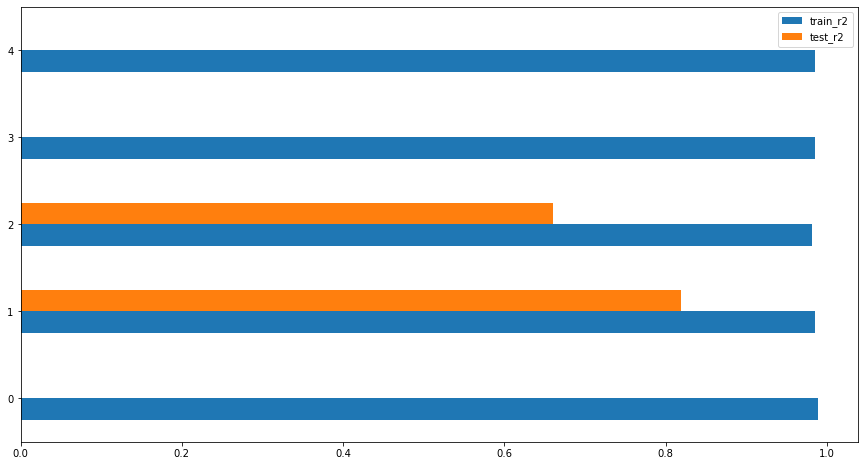

In [79]:
cv_result_xgb_model[["train_r2", "test_r2"]].plot(kind="barh", figsize=(15, 8));

### Feature importances

In [57]:
from xgboost import plot_importance
import xgboost as xgb

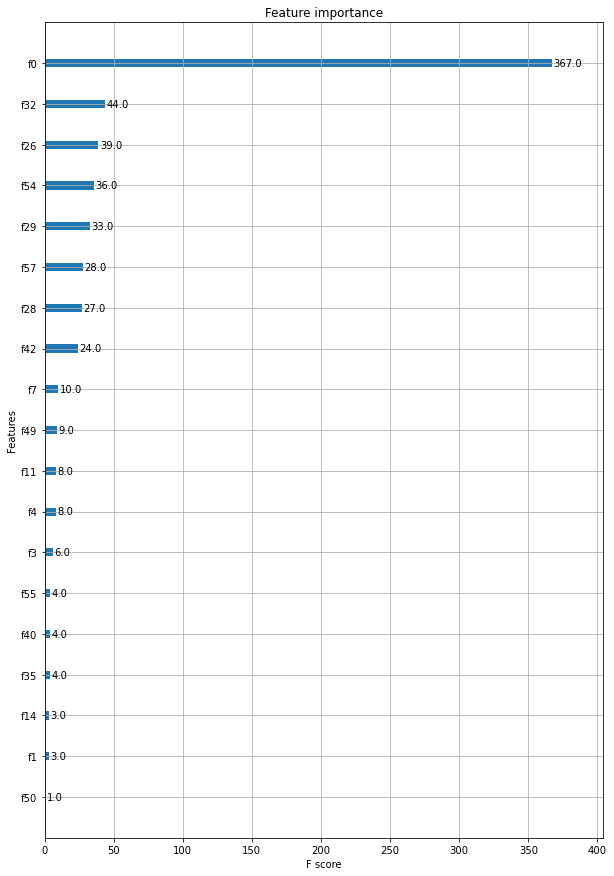

In [62]:
xgb.plot_importance(xgb_model[1])
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

### Prédiction 

In [90]:
test = pd.read_csv('test.csv')

In [91]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [92]:
test['date_block_num']=34

In [93]:
test['shop_id'] =test['shop_id'].astype(str)


In [94]:
final_train_df["shop_id"].unique()

array(['0', '1', '2', '3', '4', '6', '7', '8', '10', '12', '13', '14',
       '15', '16', '18', '19', '21', '22', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '35', '37', '38', '41', '42', '43',
       '44', '45', '46', '47', '50', '51', '52', '53', '54', '56', '59',
       '5', '57', '58', '55', '17', '9', '49', '39', '40', '48', '34',
       '33', '20', '11'], dtype=object)

In [95]:
test_group = test.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'ID':'count'}).drop('ID', axis =1)
test_group = test_group.loc[test_group.shop_id.isin(final_train_df["shop_id"].unique()), :]
test_group.head()

,shop_id,date_block_num
0,10,34
1,12,34
2,14,34
3,15,34
4,16,34


In [97]:
prediction = xgb_model.predict(test_group)

In [99]:
test_group['prediction']=prediction

In [107]:
prediction_significative = test_group.loc[test_group.prediction!=1434.786255]

In [109]:
prediction_significative.head(20)

,shop_id,date_block_num,prediction
0,10,34,1351.352661
11,25,34,5128.038574
13,28,34,2981.384766
15,31,34,6475.961426
16,34,34,1287.189087
24,42,34,3228.170654
30,49,34,1386.714844
35,55,34,1600.860718
37,57,34,2503.971680
40,6,34,1543.302246
